# Hybrid Recommendation System

## Overview
Hybrid recommendation combines multiple algorithms to leverage their complementary strengths. This system integrates User-CF, Item-CF, Content-CF, Model-CF, and Trending approaches using adaptive weighting based on user scenarios. New users receive trending items, cold users get content-based suggestions, and warm users benefit from collaborative filtering. This approach handles diverse user states while maximizing recommendation quality.

## Notebook Structure
1. **Setup**: Import libraries, configure paths, and set scenario thresholds
2. **Model Loading**: Load all five base models (user, item, content, model, trending)
3. **Scenario Detection**: Classify users as new/cold/warm based on interaction count
4. **Adaptive Weighting**: Dynamic weight assignment per scenario with activity-based adjustment
5. **Hybrid Prediction**: Combine predictions from available models using weighted averaging
6. **Evaluation**: Ranking metrics (Recall@K, NDCG@K, MAP@K) and cross-model comparison

## Process Flow
**Pipeline:**
- Load all base models for category → Initialize adaptive weight calculator
- For each user: Detect scenario (new/cold/warm) → Get predictions from each model → Calculate adaptive weights
- Combine predictions: `hybrid_score = Σ(weight_i * score_i)` → Generate top-N recommendations
- Evaluate on validation and test sets → Save configuration and compare with base models

**Weight Strategies:**
- New user (0 ratings): 100% Trending
- Cold user (<5 ratings): Content 30%, Trending 40%, CF 30%
- Warm user (≥5 ratings): User-CF 25%, Item-CF 35%, Content 20%, Model 20%

In [1]:
import os, sys, json, pickle, time
import numpy as np, polars as pl
from pathlib import Path
from scipy.sparse import load_npz
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..', 'utilities'))
sys.path.append(module_path)

from logger import Logger
from configurations import Configurations
from visualization_helpers import visualize_final_results
from evaluation_metrics import recall_at_k, ndcg_at_k, map_at_k

logger = Logger(process_name="hybrid", log_file=Configurations.LOG_PATH)

PROCESSED_DIR = Path(Configurations.DATA_PROCESSED_PATH)
MODELS_DIR = Path(Configurations.MODELS_PATH)
CATEGORY = Configurations.CATEGORIES
EVAL_K_VALUES = [10, 20, 50]

logger.log_info("="*70)
logger.log_info("HYBRID RECOMMENDATION SYSTEM")
logger.log_info(f"Categories: {CATEGORY} | Sample: {Configurations.DEV_SAMPLE_SIZE}")
logger.log_info("="*70 + "\n")

N_RECS = 10
COLD_USER_THRESHOLD = 5

2025-11-03 01:44:26,528 - INFO - ======================================================================
2025-11-03 01:44:26,529 - INFO - HYBRID RECOMMENDATION SYSTEM
2025-11-03 01:44:26,529 - INFO - Categories: ['Electronics', 'Beauty_and_Personal_Care', 'Sports_and_Outdoors'] | Sample: big
2025-11-03 01:44:26,529 - INFO - ======================================================================



In [2]:
def _candidate_files(category: str, split: str = "train"):
    dev_sample = Configurations.DEV_SAMPLE_SIZE
    safe_cat = category.replace('/', '-')
    if dev_sample != 'full':
        for size_name in Configurations.SAMPLE_SIZES.keys():
            if size_name == dev_sample:
                return PROCESSED_DIR / f"{safe_cat}.5core.{split}.{size_name}.parquet"
    return PROCESSED_DIR / f"{safe_cat}.5core.{split}.parquet"

def load_5core_data(category: str, split: str = "train") -> pl.DataFrame:
    p = _candidate_files(category, split)
    df = pl.read_parquet(p, low_memory=False)
    logger.log_info(f"[{split.upper()}] shape={df.shape} | users={df['user_id'].n_unique()} | items={df['parent_asin'].n_unique()}")
    return df

In [3]:
def load_all_models(category: str):
    logger.log_info(f"Loading all models for {category}...")
    models = {}
    
    for algo, dir_name in [('user', 'user'), ('item', 'item'), ('content', 'content'), 
                           ('model', 'model'), ('trending', 'trending')]:
        model_dir = MODELS_DIR / dir_name / category
        if not model_dir.exists():
            continue
        
        try:
            if algo == 'user':
                R = load_npz(model_dir / "R.npz")
                Rc = load_npz(model_dir / "Rc.npz") if (model_dir / "Rc.npz").exists() else None
                user_means = np.load(model_dir / "user_means.npy")
                with open(model_dir / "nn_model.pkl", "rb") as f: nn_model = pickle.load(f)
                with open(model_dir / "user_rev.pkl", "rb") as f: user_rev = pickle.load(f)
                with open(model_dir / "item_rev.pkl", "rb") as f: item_rev = pickle.load(f)
                user_idx = json.loads((model_dir / "user_idx.json").read_text())
                item_idx = json.loads((model_dir / "item_idx.json").read_text())
                models['user'] = {'R': R, 'Rc': Rc, 'user_means': user_means, 'nn_model': nn_model,
                                 'user_rev': user_rev, 'item_rev': item_rev, 'user_idx': user_idx, 'item_idx': item_idx,
                                 'k_neighbors': Configurations.load_best_k(category)}
                logger.log_info(f"  [1/5] User-CF loaded (K={models['user']['k_neighbors']})")
            
            elif algo == 'item':
                R = load_npz(model_dir / "R.npz")
                Rc = load_npz(model_dir / "Rc.npz") if (model_dir / "Rc.npz").exists() else None
                user_means = np.load(model_dir / "user_means.npy")
                item_similarity = load_npz(model_dir / "item_similarity.npz")
                with open(model_dir / "user_rev.pkl", "rb") as f: user_rev = pickle.load(f)
                with open(model_dir / "item_rev.pkl", "rb") as f: item_rev = pickle.load(f)
                user_idx = json.loads((model_dir / "user_idx.json").read_text())
                item_idx = json.loads((model_dir / "item_idx.json").read_text())
                models['item'] = {'R': R, 'Rc': Rc, 'user_means': user_means, 'item_similarity': item_similarity,
                                 'user_rev': user_rev, 'item_rev': item_rev, 'user_idx': user_idx, 'item_idx': item_idx,
                                 'top_k_similar': Configurations.load_best_k_item(category)}
                logger.log_info(f"  [2/5] Item-CF loaded (K={models['item']['top_k_similar']})")
            
            elif algo == 'content':
                R = load_npz(model_dir / "R.npz")
                item_similarity = load_npz(model_dir / "item_similarity.npz")
                with open(model_dir / "user_rev.pkl", "rb") as f: user_rev = pickle.load(f)
                with open(model_dir / "item_rev.pkl", "rb") as f: item_rev = pickle.load(f)
                user_idx = json.loads((model_dir / "user_idx.json").read_text())
                item_idx = json.loads((model_dir / "item_idx.json").read_text())
                models['content'] = {'R': R, 'item_similarity': item_similarity,
                                    'user_rev': user_rev, 'item_rev': item_rev, 'user_idx': user_idx, 'item_idx': item_idx,
                                    'top_k_similar': Configurations.load_best_k_content(category)}
                logger.log_info(f"  [3/5] Content-CF loaded (K={models['content']['top_k_similar']})")
            
            elif algo == 'model':
                R = load_npz(model_dir / "R.npz")
                U = np.load(model_dir / "U.npy")
                V = np.load(model_dir / "V.npy")
                with open(model_dir / "user_rev.pkl", "rb") as f: user_rev = pickle.load(f)
                with open(model_dir / "item_rev.pkl", "rb") as f: item_rev = pickle.load(f)
                user_idx = json.loads((model_dir / "user_idx.json").read_text())
                item_idx = json.loads((model_dir / "item_idx.json").read_text())
                models['model'] = {'R': R, 'U': U, 'V': V, 'user_rev': user_rev, 'item_rev': item_rev,
                                  'user_idx': user_idx, 'item_idx': item_idx,
                                  'n_factors': Configurations.load_best_factors(category)}
                logger.log_info(f"  [4/5] Model-CF loaded (factors={models['model']['n_factors']})")
            
            elif algo == 'trending':
                item_stats = pl.read_parquet(model_dir / "item_stats.parquet")
                R = load_npz(model_dir / "R.npz")
                with open(model_dir / "user_rev.pkl", "rb") as f: user_rev = pickle.load(f)
                with open(model_dir / "item_rev.pkl", "rb") as f: item_rev = pickle.load(f)
                user_idx = json.loads((model_dir / "user_idx.json").read_text())
                item_idx = json.loads((model_dir / "item_idx.json").read_text())
                models['trending'] = {'item_stats': item_stats, 'R': R, 'user_rev': user_rev, 'item_rev': item_rev,
                                     'user_idx': user_idx, 'item_idx': item_idx}
                logger.log_info(f"  [5/5] Trending loaded")
        
        except Exception as e:
            logger.log_warning(f"  Failed to load {algo}: {e}")
    
    logger.log_info(f"Loaded {len(models)} models\n")
    return models

In [4]:
def detect_user_scenario(user_id: str, models: dict, threshold: int = 5):
    for model_name in ['user', 'item', 'content', 'model']:
        if model_name not in models:
            continue
        user_idx = models[model_name].get('user_idx', {})
        if user_id not in user_idx:
            continue
        R = models[model_name].get('R')
        if R is None:
            continue
        u = int(user_idx[user_id])
        n_ratings = R.getrow(u).nnz
        if n_ratings == 0:
            return 'new-user', 0
        elif n_ratings < threshold:
            return 'cold-user', n_ratings
        else:
            return 'warm-user', n_ratings
    return 'new-user', 0

In [5]:
def predict_user_cf(user_id: str, models: dict):
    if 'user' not in models or user_id not in models['user']['user_idx']:
        return None
    art = models['user']
    u = int(art['user_idx'][user_id])
    X = art['Rc'] if art.get('Rc') is not None else art['R']
    nn_model, k = art['nn_model'], art.get('k_neighbors', 30)
    
    if isinstance(nn_model, dict) and 'similarity' in nn_model:
        user_sims = nn_model['similarity'][u]
        top_k_idx = np.argsort(-user_sims)[:k]
        sims = user_sims[top_k_idx]
    else:
        distances, indices = nn_model.kneighbors(X.getrow(u), return_distance=True)
        d, idx = distances.ravel(), indices.ravel()
        mask = idx != u
        top_k_idx, sims = idx[mask][:k], np.clip(1.0 - d[mask][:k], 0.0, 1.0)
    
    if len(top_k_idx) == 0:
        return None
    
    sims = np.clip(sims, 0, None)
    scores = X[top_k_idx, :].T.dot(sims) / (np.sum(np.abs(sims)) + 1e-8)
    if art.get('Rc') is not None:
        scores = scores + art['user_means'][u]
    return scores

def predict_item_cf(user_id: str, models: dict):
    if 'item' not in models or user_id not in models['item']['user_idx']:
        return None
    art = models['item']
    u = int(art['user_idx'][user_id])
    R, Rc = art['R'], art.get('Rc')
    X = Rc if Rc is not None else R
    user_ratings = X.getrow(u).toarray().ravel()
    rated_items = np.nonzero(R.getrow(u).toarray().ravel())[0]
    
    if len(rated_items) == 0:
        return None
    
    item_sim = art['item_similarity']
    top_k = art.get('top_k_similar', 30)
    scores = np.zeros(R.shape[1], dtype=np.float32)
    sim_matrix = item_sim[:, rated_items].toarray()
    
    for i in range(R.shape[1]):
        sims = sim_matrix[i, :]
        positive_mask = sims > 0
        if not positive_mask.any():
            continue
        sims_pos = sims[positive_mask]
        ratings_pos = user_ratings[rated_items[positive_mask]]
        k_use = min(top_k, len(sims_pos))
        if k_use > 0:
            top_idx = np.arange(len(sims_pos)) if k_use >= len(sims_pos) else \
                     np.argpartition(-sims_pos, k_use-1)[:k_use]
            sim_sum = np.sum(sims_pos[top_idx])
            if sim_sum > 1e-8:
                scores[i] = np.dot(sims_pos[top_idx], ratings_pos[top_idx]) / sim_sum
    
    if Rc is not None:
        scores = scores + art['user_means'][u]
    return scores

def predict_content_cf(user_id: str, models: dict):
    if 'content' not in models or user_id not in models['content']['user_idx']:
        return None
    art = models['content']
    u = int(art['user_idx'][user_id])
    R = art['R']
    user_ratings = R.getrow(u).toarray().ravel()
    rated_items = np.nonzero(user_ratings)[0]
    
    if len(rated_items) == 0:
        return None
    
    item_sim = art['item_similarity']
    top_k = art.get('top_k_similar', 30)
    scores = np.zeros(R.shape[1], dtype=np.float32)
    sim_matrix = item_sim[:, rated_items].toarray()
    
    for i in range(R.shape[1]):
        sims = sim_matrix[i, :]
        positive_mask = sims > 0
        if not positive_mask.any():
            continue
        sims_pos = sims[positive_mask]
        ratings_pos = user_ratings[rated_items[positive_mask]]
        k_use = min(top_k, len(sims_pos))
        if k_use > 0:
            top_idx = np.arange(len(sims_pos)) if k_use >= len(sims_pos) else \
                     np.argpartition(-sims_pos, k_use-1)[:k_use]
            sim_sum = np.sum(sims_pos[top_idx])
            if sim_sum > 1e-8:
                scores[i] = np.dot(sims_pos[top_idx], ratings_pos[top_idx]) / sim_sum
    return scores

def predict_model_cf(user_id: str, models: dict):
    if 'model' not in models or user_id not in models['model']['user_idx']:
        return None
    art = models['model']
    u = int(art['user_idx'][user_id])
    return art['U'][u] @ art['V'].T

def get_trending_items(models: dict, n_items: int = 100):
    if 'trending' not in models:
        return None
    art = models['trending']
    top_items = art['item_stats']['parent_asin'].to_list()[:n_items]
    item_idx = art['item_idx']
    scores = np.zeros(len(item_idx), dtype=np.float32)
    for rank, item in enumerate(top_items):
        if item in item_idx:
            scores[int(item_idx[item])] = 1.0 / (rank + 1)
    return scores

In [6]:
class AdaptiveWeights:
    def __init__(self):
        self.configs = {
            'new-user': {'user': 0.0, 'item': 0.0, 'content': 0.0, 'model': 0.0, 'trending': 1.0},
            'cold-user': {'user': 0.1, 'item': 0.1, 'content': 0.1, 'model': 0.35, 'trending': 0.35},
            'warm-user': {'user': 0.1, 'item': 0.1, 'content': 0.10, 'model': 0.3, 'trending': 0.3}
        }
    
    def get_weights(self, scenario: str, available_models: list, n_ratings: int = 0):
        base = self.configs.get(scenario, self.configs['warm-user'])
        weights = {m: w for m, w in base.items() if m in available_models}
        
        if scenario == 'cold-user' and n_ratings >= 3:
            if 'user' in weights: weights['user'] *= 1.5
            if 'item' in weights: weights['item'] *= 1.5
            if 'trending' in weights: weights['trending'] *= 0.7
        elif scenario == 'warm-user' and n_ratings > 20:
            if 'user' in weights: weights['user'] *= 1.2
            if 'item' in weights: weights['item'] *= 1.2
        
        total = sum(weights.values())
        return {k: v / total for k, v in weights.items()} if total > 0 else weights

In [7]:
def predict_hybrid(user_id: str, models: dict, weight_calc: AdaptiveWeights):
    scenario, n_ratings = detect_user_scenario(user_id, models, COLD_USER_THRESHOLD)
    
    predictions = {}
    for name, predict_fn in [('user', predict_user_cf), ('item', predict_item_cf), 
                             ('content', predict_content_cf), ('model', predict_model_cf)]:
        scores = predict_fn(user_id, models)
        if scores is not None:
            predictions[name] = scores
    
    trending_scores = get_trending_items(models, n_items=100)
    if trending_scores is not None:
        predictions['trending'] = trending_scores
    
    if not predictions:
        return None, "no_models", {}
    
    available = list(predictions.keys())
    weights = weight_calc.get_weights(scenario, available, n_ratings)
    
    ref_model = available[0]
    combined = np.zeros(len(predictions[ref_model]), dtype=np.float32)
    for model_name, scores in predictions.items():
        weight = weights.get(model_name, 0.0)
        if weight > 0:
            combined += weight * scores
    
    strategy_parts = [f"{m}({w*100:.0f}%)" for m, w in sorted(weights.items(), key=lambda x: -x[1]) if w > 0.05]
    strategy = f"hybrid-{scenario}-" + "+".join(strategy_parts)
    
    return combined, strategy, {'scenario': scenario, 'n_ratings': n_ratings, 'weights': weights, 'models': available}

def recommend_hybrid(user_id: str, n_recs: int, models: dict, weight_calc: AdaptiveWeights):
    scores, strategy, metadata = predict_hybrid(user_id, models, weight_calc)
    
    if scores is None:
        return pl.DataFrame({"parent_asin": [], "score": []}), strategy
    
    ref_model = metadata['models'][0]
    R, item_rev, user_idx = models[ref_model]['R'], models[ref_model]['item_rev'], models[ref_model]['user_idx']
    
    rated = set()
    if user_id in user_idx:
        rated = set(R.getrow(int(user_idx[user_id])).indices.tolist())
    
    cand_mask = np.ones(len(scores), dtype=bool)
    if rated:
        cand_mask[list(rated)] = False
    
    cand_scores = scores[cand_mask]
    if cand_scores.size == 0:
        return pl.DataFrame({"parent_asin": [], "score": []}), strategy
    
    n_top = min(n_recs, cand_scores.size)
    cand_indices = np.nonzero(cand_mask)[0]
    top_pos = np.argpartition(-cand_scores, n_top - 1)[:n_top]
    top_pos = top_pos[np.argsort(-cand_scores[top_pos])]
    
    return pl.DataFrame({"parent_asin": [item_rev[cand_indices[i]] for i in top_pos],
                        "score": [float(cand_scores[i]) for i in top_pos]}), strategy

In [8]:
def evaluate_hybrid(category: str, models: dict, weight_calc: AdaptiveWeights,
                   k_values: list = None, split: str = "test", sample_users: int = 1000):
    if k_values is None:
        k_values = [10, 20, 50]
    
    df_eval = load_5core_data(category, split=split)
    
    train_users = None
    for model_name in ['user', 'item', 'content', 'model']:
        if model_name in models:
            train_users = list(models[model_name]['user_idx'].keys())
            break
    
    if train_users is None:
        return None
    
    df_eval = df_eval.filter(pl.col('user_id').is_in(train_users))
    if len(df_eval) == 0:
        return None
    
    eval_users = df_eval['user_id'].unique().to_list()
    if len(eval_users) > sample_users:
        np.random.seed(42)
        eval_users = np.random.choice(eval_users, sample_users, replace=False).tolist()
    
    metrics_acc = {f'{m}@{k}': [] for m in ['recall', 'ndcg', 'map'] for k in k_values}
    scenario_counts = {'new-user': 0, 'cold-user': 0, 'warm-user': 0}
    
    for user_id in eval_users:
        user_eval = df_eval.filter(pl.col('user_id') == user_id)
        relevant = set(user_eval.filter(pl.col('rating') >= 4)['parent_asin'].to_list())
        if not relevant:
            continue
        
        recs_df, strategy = recommend_hybrid(user_id, n_recs=50, models=models, weight_calc=weight_calc)
        if len(recs_df) == 0:
            continue
        
        recommended = recs_df['parent_asin'].to_list()
        scenario = strategy.split('-')[1] if len(strategy.split('-')) > 1 else 'unknown'
        scenario_counts[scenario] = scenario_counts.get(scenario, 0) + 1
        
        for k in k_values:
            metrics_acc[f'recall@{k}'].append(recall_at_k(recommended, relevant, k))
            metrics_acc[f'ndcg@{k}'].append(ndcg_at_k(recommended, relevant, k))
            metrics_acc[f'map@{k}'].append(map_at_k(recommended, relevant, k))
    
    logger.log_info(f"[Eval] Scenarios: {scenario_counts}")
    
    results = {'category': category, 'split': split, 'n_users': len(eval_users),
               'rmse': np.nan, 'accuracy': np.nan}
    
    for k in k_values:
        for metric in ['recall', 'ndcg', 'map']:
            key = f'{metric}@{k}'
            results[key] = np.mean(metrics_acc[key]) if metrics_acc[key] else 0.0
    
    logger.log_info(f"[Eval] NDCG@10={results['ndcg@10']:.4f}, Recall@10={results['recall@10']:.4f}")
    return results

In [9]:
def save_hybrid_config(out_dir: Path, weight_calc: AdaptiveWeights, metadata: dict):
    out_dir.mkdir(parents=True, exist_ok=True)
    config = {'weight_configs': weight_calc.configs, 'cold_threshold': COLD_USER_THRESHOLD, 'metadata': metadata}
    with open(out_dir / 'config.json', 'w') as f:
        json.dump(config, f, indent=2)

def run_hybrid_pipeline(category: str):
    logger.log_info(f"\n{'='*70}\n{category}\n{'='*70}")
    
    models = load_all_models(category)
    if len(models) < 2:
        logger.log_warning(f"Not enough models ({len(models)}), need >= 2")
        return None
    
    weight_calc = AdaptiveWeights()
    
    val_results = evaluate_hybrid(category, models, weight_calc, k_values=EVAL_K_VALUES,
                                 split="valid", sample_users=Configurations.get_eval_samples_tuning())
    test_results = evaluate_hybrid(category, models, weight_calc, k_values=EVAL_K_VALUES,
                                  split="test", sample_users=Configurations.get_eval_samples_final())
    
    save_hybrid_config(MODELS_DIR / 'hybrid' / category, weight_calc, 
                      {'models_used': list(models.keys()), 'category': category})
    
    logger.log_info(f"\nComplete\n")
    return {'val_results': val_results, 'test_results': test_results, 'models_used': list(models.keys())}

In [10]:
logger.log_info("HYBRID SYSTEM - ALL CATEGORIES\n")
hybrid_results = {}

for cat in CATEGORY:
    try:
        result = run_hybrid_pipeline(cat)
        if result:
            hybrid_results[cat] = result
    except Exception as e:
        logger.log_exception(f"{cat}: {e}")

2025-11-03 01:44:26,756 - INFO - HYBRID SYSTEM - ALL CATEGORIES

2025-11-03 01:44:26,765 - INFO - 
Electronics
2025-11-03 01:44:26,766 - INFO - Loading all models for Electronics...
2025-11-03 01:44:28,422 - INFO -   [1/5] User-CF loaded (K=10)
2025-11-03 01:44:28,441 - INFO -   [2/5] Item-CF loaded (K=10)
2025-11-03 01:44:28,455 - INFO -   [3/5] Content-CF loaded (K=10)
2025-11-03 01:44:28,470 - INFO -   [4/5] Model-CF loaded (factors=10)
2025-11-03 01:44:28,486 - INFO -   [5/5] Trending loaded
2025-11-03 01:44:28,487 - INFO - Loaded 5 models

2025-11-03 01:44:28,488 - INFO - [VALID] shape=(456, 4) | users=456 | items=26
2025-11-03 01:44:28,963 - INFO - [Eval] Scenarios: {'new-user': 0, 'cold-user': 0, 'warm-user': 0, 'cold': 388, 'warm': 3}
2025-11-03 01:44:28,964 - INFO - [Eval] NDCG@10=0.2113, Recall@10=0.4373
2025-11-03 01:44:28,967 - INFO - [TEST] shape=(349, 4) | users=349 | items=27
2025-11-03 01:44:29,334 - INFO - [Eval] Scenarios: {'new-user': 0, 'cold-user': 0, 'warm-user': 

2025-11-03 01:44:30,790 - INFO - 
SAVING RESULTS



category,split,n_users,rmse,accuracy,recall@10,ndcg@10,map@10,recall@20,ndcg@20,map@20,recall@50,ndcg@50,map@50
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Electronics""","""valid""",456,NaN,NaN,0.43734,0.211253,0.141673,0.73913,0.287224,0.162387,1.0,0.34342,0.173285
"""Beauty_and_Personal_Care""","""valid""",336,NaN,NaN,0.511628,0.239777,0.157915,0.94186,0.348097,0.187367,1.0,0.361048,0.190076
"""Sports_and_Outdoors""","""valid""",157,NaN,NaN,0.458904,0.212291,0.137758,0.917808,0.327855,0.169253,1.0,0.346155,0.173077


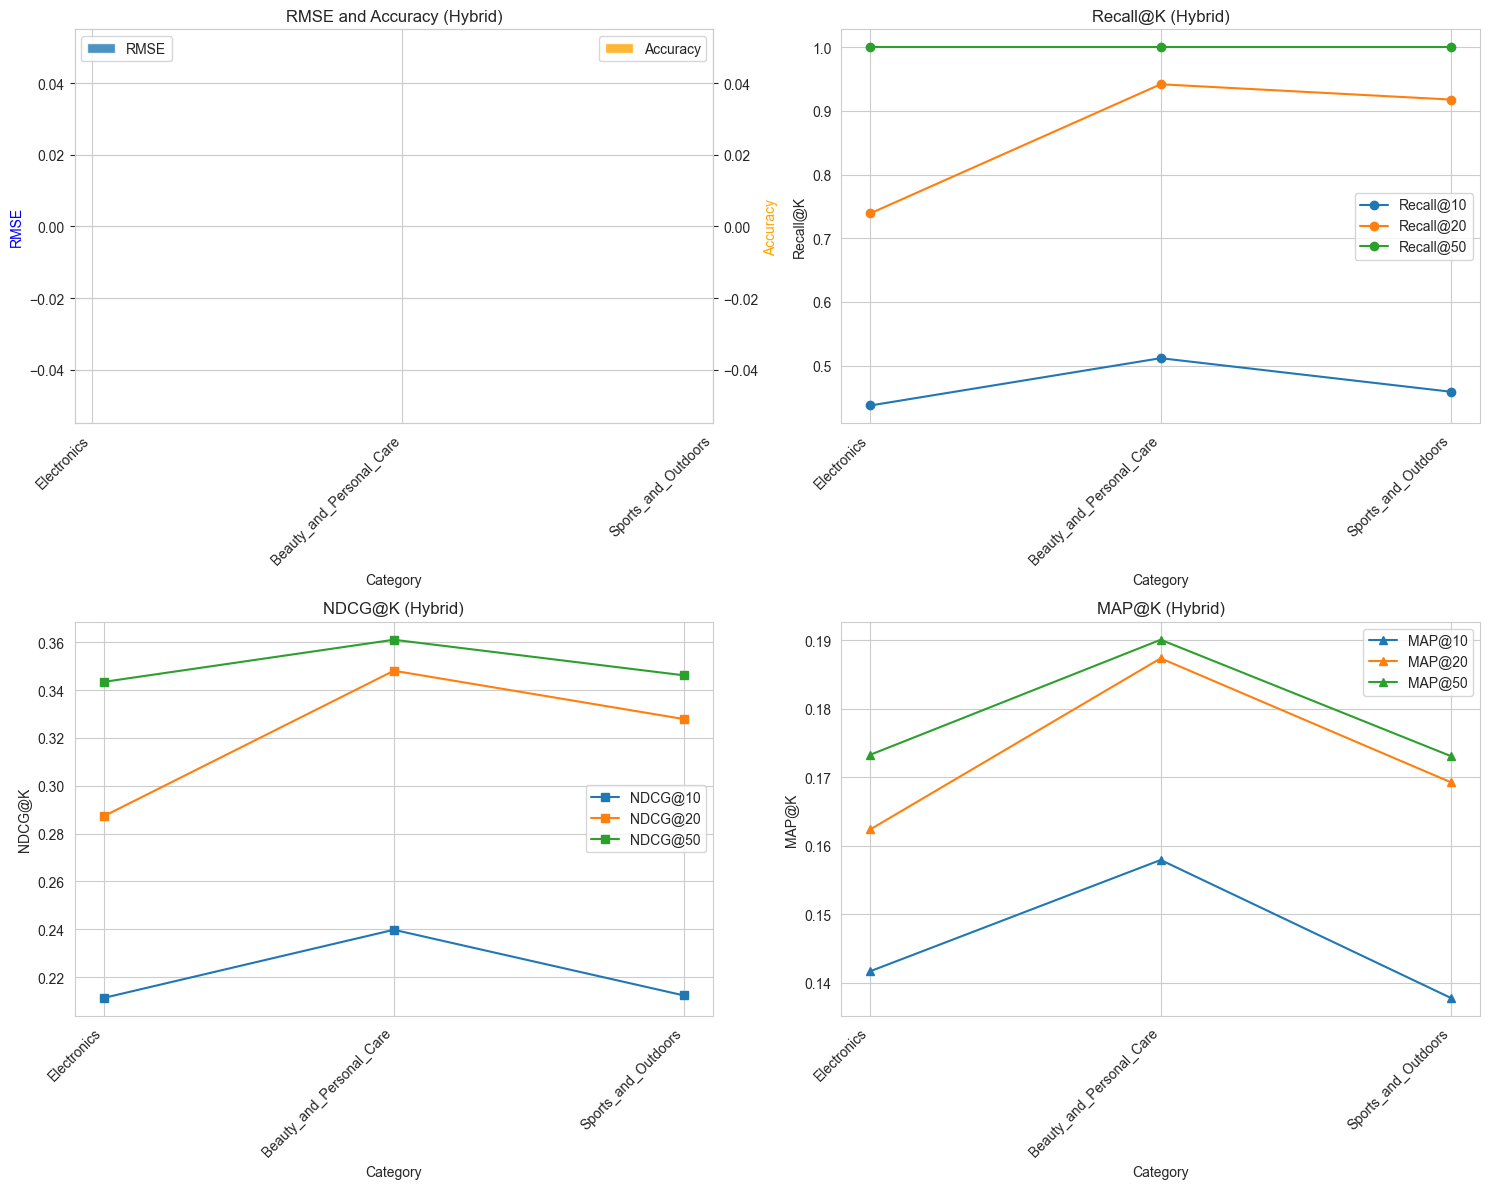

2025-11-03 01:44:31,656 - INFO - 
COMPLETE


In [11]:
logger.log_info("\nSAVING RESULTS\n")

test_results = [hybrid_results[cat]['test_results'] for cat in CATEGORY 
                if cat in hybrid_results and hybrid_results[cat]['test_results']]

if test_results:
    df_final = pl.DataFrame(test_results)
    display(df_final)
    df_final.write_csv(MODELS_DIR / 'hybrid' / 'final_test_results.csv')
    visualize_final_results(test_results, save_dir=MODELS_DIR / 'hybrid',
                           algo_name='Hybrid', k_values=EVAL_K_VALUES)

logger.log_info("\nCOMPLETE")

### Compare all models based on their performance across different categories

#### All

algorithm,category,rmse,accuracy,ndcg@10,recall@10,map@10
str,str,f64,f64,f64,f64,f64
"""user""","""Electronics""",0.864216,0.830946,0.200339,0.404011,0.137537
"""user""","""Beauty_and_Personal_Care""",0.777479,0.733553,0.183392,0.430921,0.110045
"""user""","""Sports_and_Outdoors""",0.86431,0.829932,0.255376,0.557823,0.165633
"""item""","""Electronics""",0.864003,0.833811,0.268797,0.613181,0.168222
"""item""","""Beauty_and_Personal_Care""",0.776767,0.733553,0.1934,0.516447,0.098471
…,…,…,…,…,…,…
"""trending""","""Beauty_and_Personal_Care""",NaN,NaN,0.190708,0.486957,0.104947
"""trending""","""Sports_and_Outdoors""",NaN,NaN,0.310221,0.615385,0.217036
"""hybrid""","""Electronics""",NaN,NaN,0.211253,0.43734,0.141673


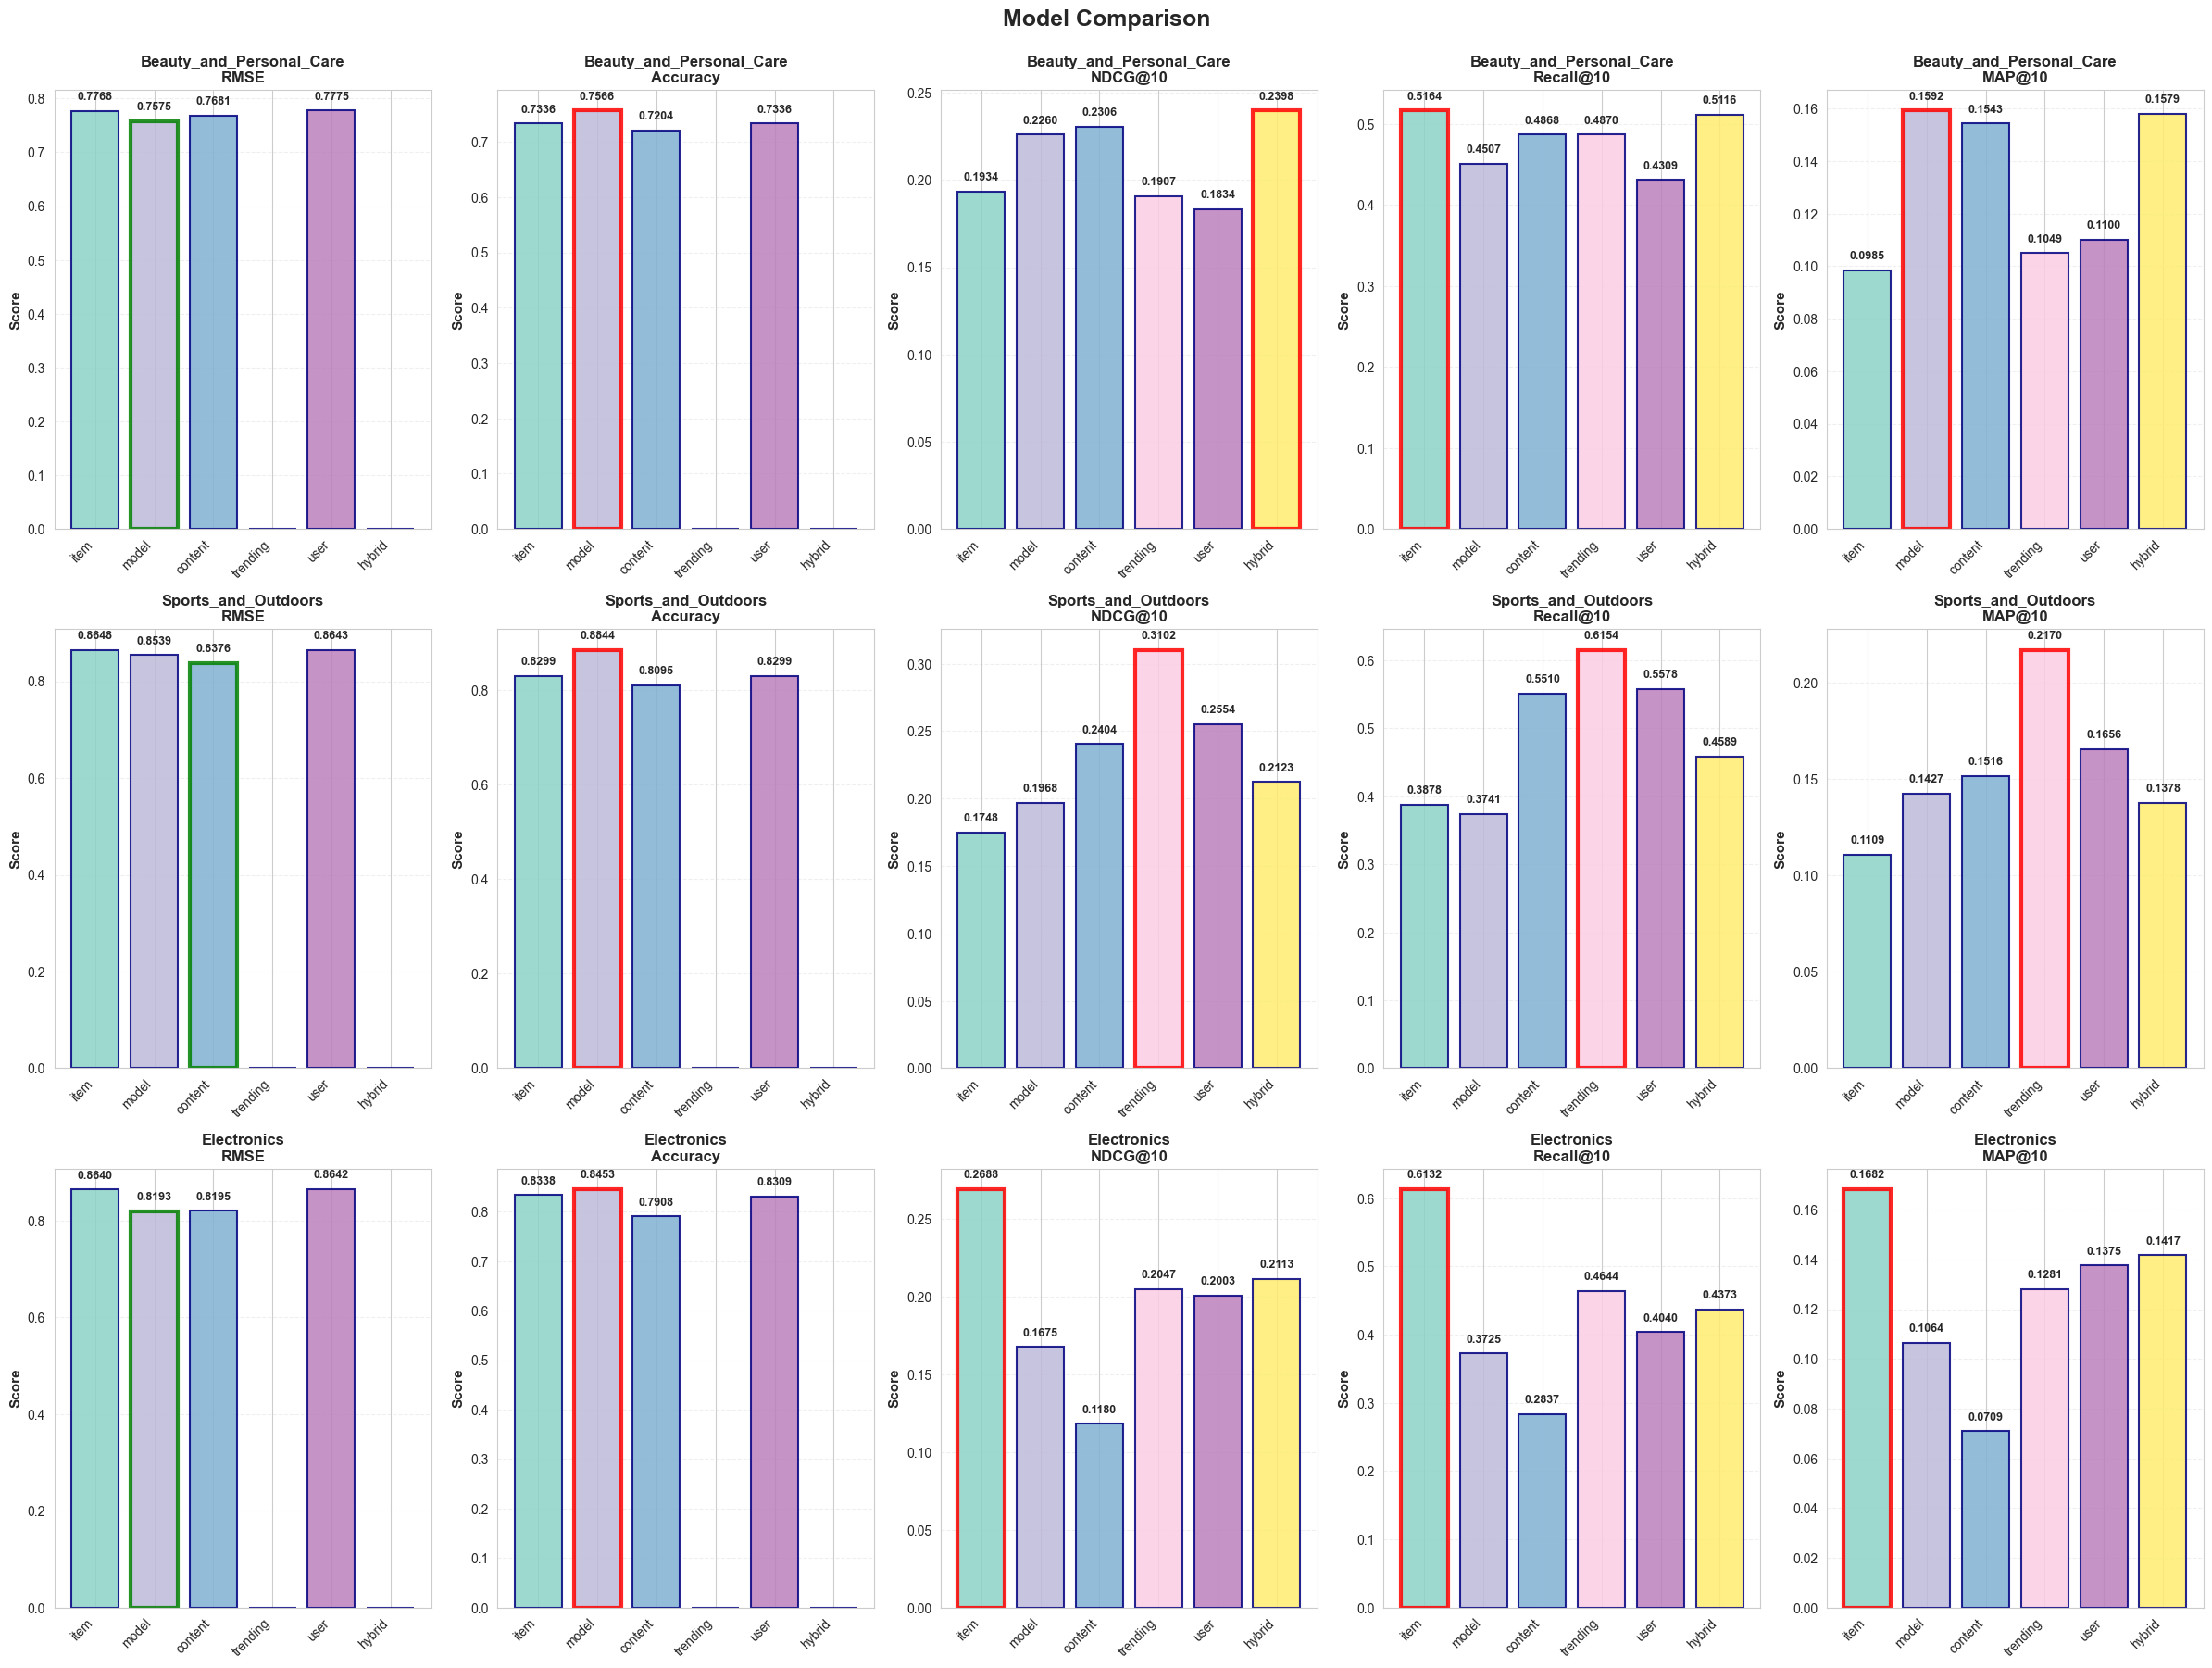

category,best_rmse,rmse,best_accuracy,accuracy,best_ndcg@10,ndcg@10,best_recall@10,recall@10,best_map@10,map@10
str,str,f64,str,f64,str,f64,str,f64,str,f64
"""Beauty_and_Personal_Care""","""model""",0.757518,"""trending""",NaN,"""hybrid""",0.239777,"""item""",0.516447,"""model""",0.159182
"""Sports_and_Outdoors""","""content""",0.837605,"""trending""",NaN,"""trending""",0.310221,"""trending""",0.615385,"""trending""",0.217036
"""Electronics""","""model""",0.819348,"""trending""",NaN,"""item""",0.268797,"""item""",0.613181,"""item""",0.168222


category,split,n_users,rmse,accuracy,recall@10,ndcg@10,map@10,recall@20,ndcg@20,map@20,recall@50,ndcg@50,map@50,algorithm
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""Electronics""","""test""",349,0.864216,0.830946,0.404011,0.200339,0.137537,0.716332,0.277003,0.157352,1.0,0.338285,0.169309,"""user"""
"""Beauty_and_Personal_Care""","""test""",304,0.777479,0.733553,0.430921,0.183392,0.110045,0.917763,0.303398,0.141401,1.0,0.321734,0.145246,"""user"""
"""Sports_and_Outdoors""","""test""",147,0.86431,0.829932,0.557823,0.255376,0.165633,0.918367,0.346524,0.190682,1.0,0.364786,0.19454,"""user"""
"""Electronics""","""test""",349,0.864003,0.833811,0.613181,0.268797,0.168222,0.776504,0.308113,0.177988,1.0,0.356318,0.187364,"""item"""
"""Beauty_and_Personal_Care""","""test""",304,0.776767,0.733553,0.516447,0.1934,0.098471,0.944079,0.299547,0.126615,1.0,0.312055,0.129257,"""item"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Beauty_and_Personal_Care""","""test""",304,NaN,NaN,0.486957,0.190708,0.104947,0.952174,0.307564,0.136608,1.0,0.318178,0.138811,"""trending"""
"""Sports_and_Outdoors""","""test""",147,NaN,NaN,0.615385,0.310221,0.217036,0.969231,0.39958,0.241525,1.0,0.406338,0.242894,"""trending"""
"""Electronics""","""valid""",456,NaN,NaN,0.43734,0.211253,0.141673,0.73913,0.287224,0.162387,1.0,0.34342,0.173285,"""hybrid"""


In [12]:
def compare_all_models():
    results = []
    for algo in ['user', 'item', 'content', 'model', 'trending', 'hybrid']:
        file = MODELS_DIR / algo / 'final_test_results.csv'
        if file.exists():
            df = pl.read_csv(file).with_columns(pl.lit(algo).alias('algorithm'))
            results.append(df)
    
    if not results:
        return
    
    df_all = pl.concat(results)
    display(df_all.select(['algorithm', 'category', 'rmse', 'accuracy', 
                          'ndcg@10', 'recall@10', 'map@10']))
    df_all.write_csv(MODELS_DIR / 'comparison_all_models.csv')
    
    categories = df_all['category'].unique().to_list()
    n_cat = len(categories)
    algorithms = df_all['algorithm'].unique().to_list()
    metrics = [('rmse', 'RMSE'), ('accuracy', 'Accuracy'), ('ndcg@10', 'NDCG@10'),
               ('recall@10', 'Recall@10'), ('map@10', 'MAP@10')]
    
    fig, axes = plt.subplots(n_cat, 5, figsize=(24, 6 * n_cat))
    if n_cat == 1:
        axes = axes.reshape(1, -1)
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(algorithms)))
    
    for i, cat in enumerate(categories):
        df_cat = df_all.filter(pl.col('category') == cat)
        
        for j, (metric, name) in enumerate(metrics):
            scores = []
            for algo in algorithms:
                data = df_cat.filter(pl.col('algorithm') == algo)
                if len(data) > 0:
                    val = data[metric][0]
                    scores.append(0 if (val is None or np.isnan(val)) else val)
                else:
                    scores.append(0)
            
            ax = axes[i, j]
            bars = ax.bar(algorithms, scores, alpha=0.85, color=colors,
                         edgecolor='navy', linewidth=1.5)
            
            ax.set_ylabel('Score', fontsize=11, fontweight='bold')
            ax.set_title(f'{cat}\n{name}', fontweight='bold', fontsize=12)
            ax.set_xticks(range(len(algorithms)))
            ax.set_xticklabels(algorithms, rotation=45, ha='right', fontsize=10)
            ax.grid(axis='y', alpha=0.3, linestyle='--')
            
            for bar, v in zip(bars, scores):
                if v > 0:
                    ax.text(bar.get_x() + bar.get_width()/2., 
                           bar.get_height() + max(scores) * 0.02,
                           f'{v:.4f}', ha='center', va='bottom',
                           fontsize=9, fontweight='bold')
            
            if metric != 'rmse':
                best = np.argmax(scores)
                if scores[best] > 0:
                    bars[best].set_edgecolor('red')
                    bars[best].set_linewidth(3)
            else:
                non_zero = [s if s > 0 else float('inf') for s in scores]
                best = np.argmin(non_zero)
                if non_zero[best] < float('inf'):
                    bars[best].set_edgecolor('green')
                    bars[best].set_linewidth(3)
    
    plt.suptitle('Model Comparison', fontsize=18, fontweight='bold', y=0.998)
    plt.tight_layout()
    plt.savefig(MODELS_DIR / 'comparison_all_metrics.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    summary = []
    for cat in categories:
        df_cat = df_all.filter(pl.col('category') == cat)
        row = {'category': cat}
        
        for metric, _ in metrics:
            if metric == 'rmse':
                best = df_cat.filter(pl.col(metric).is_not_null()).sort(metric).head(1)
            else:
                best = df_cat.sort(metric, descending=True).head(1)
            
            if len(best) > 0:
                row[f'best_{metric}'] = best['algorithm'][0]
                row[metric] = best[metric][0]
        
        summary.append(row)
    
    df_summary = pl.DataFrame(summary)
    display(df_summary)
    df_summary.write_csv(MODELS_DIR / 'best_per_metric.csv')
    
    return df_all

compare_all_models()

#### Recal@10

algorithm,category,ndcg@10,recall@10,map@10
str,str,f64,f64,f64
"""user""","""Electronics""",0.200339,0.404011,0.137537
"""user""","""Beauty_and_Personal_Care""",0.183392,0.430921,0.110045
"""user""","""Sports_and_Outdoors""",0.255376,0.557823,0.165633
"""item""","""Electronics""",0.268797,0.613181,0.168222
"""item""","""Beauty_and_Personal_Care""",0.1934,0.516447,0.098471
…,…,…,…,…
"""trending""","""Beauty_and_Personal_Care""",0.190708,0.486957,0.104947
"""trending""","""Sports_and_Outdoors""",0.310221,0.615385,0.217036
"""hybrid""","""Electronics""",0.211253,0.43734,0.141673


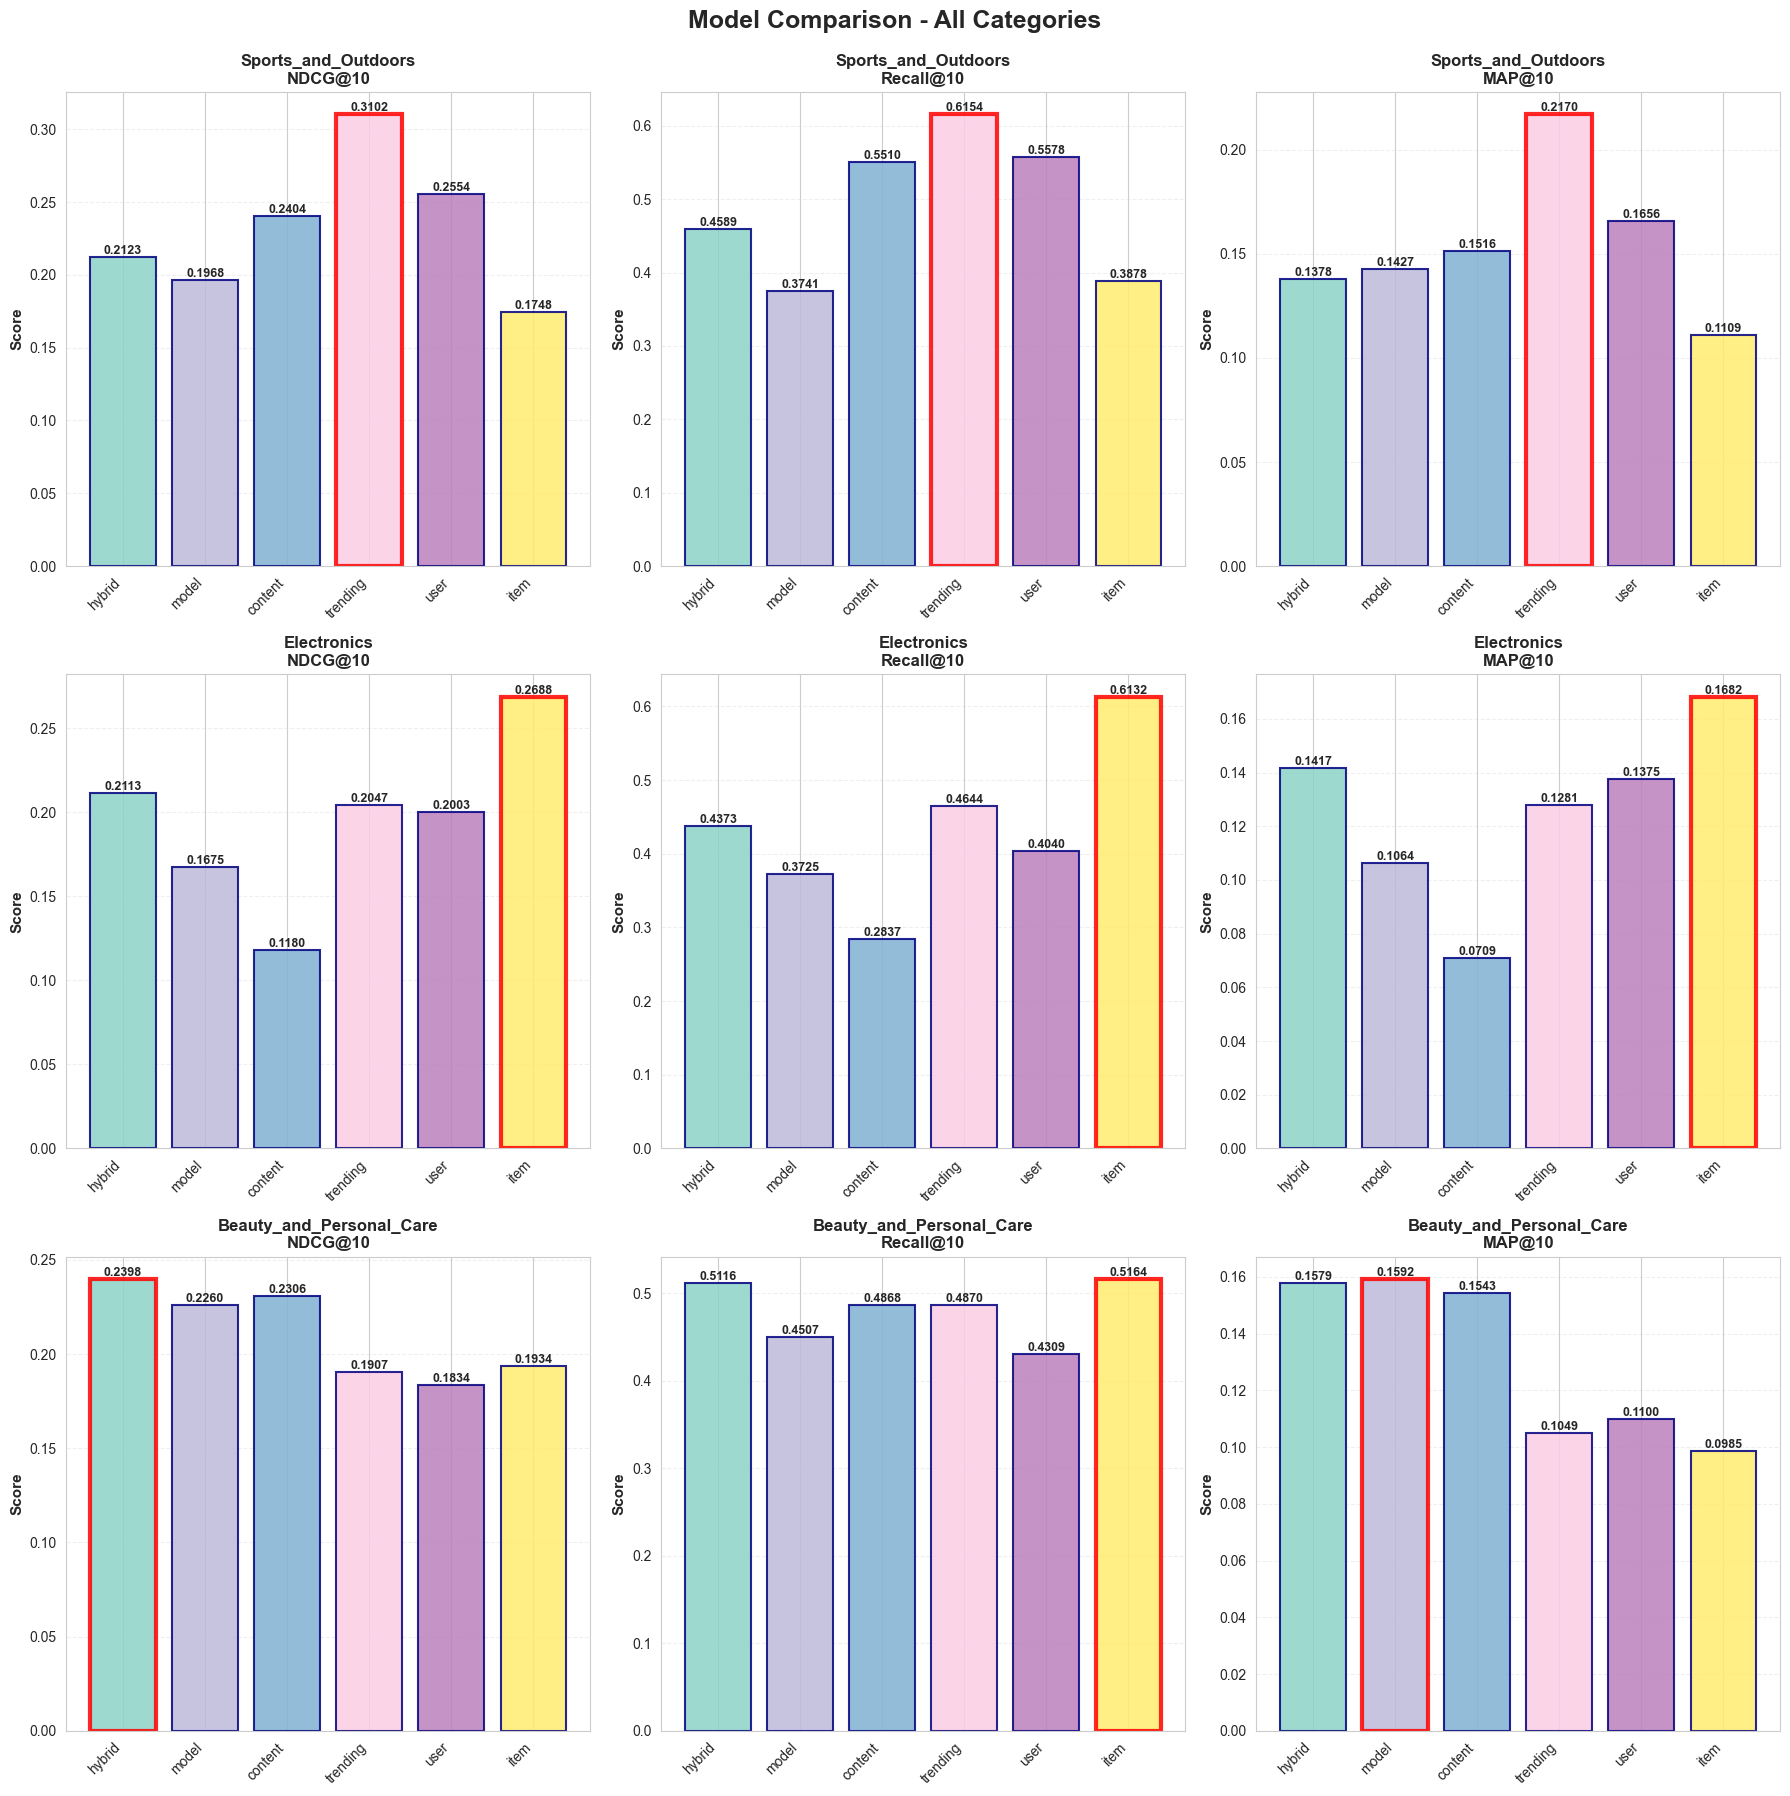

category,best_algorithm,ndcg@10
str,str,f64
"""Sports_and_Outdoors""","""trending""",0.310221
"""Electronics""","""item""",0.268797
"""Beauty_and_Personal_Care""","""hybrid""",0.239777


category,split,n_users,rmse,accuracy,recall@10,ndcg@10,map@10,recall@20,ndcg@20,map@20,recall@50,ndcg@50,map@50,algorithm
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""Electronics""","""test""",349,0.864216,0.830946,0.404011,0.200339,0.137537,0.716332,0.277003,0.157352,1.0,0.338285,0.169309,"""user"""
"""Beauty_and_Personal_Care""","""test""",304,0.777479,0.733553,0.430921,0.183392,0.110045,0.917763,0.303398,0.141401,1.0,0.321734,0.145246,"""user"""
"""Sports_and_Outdoors""","""test""",147,0.86431,0.829932,0.557823,0.255376,0.165633,0.918367,0.346524,0.190682,1.0,0.364786,0.19454,"""user"""
"""Electronics""","""test""",349,0.864003,0.833811,0.613181,0.268797,0.168222,0.776504,0.308113,0.177988,1.0,0.356318,0.187364,"""item"""
"""Beauty_and_Personal_Care""","""test""",304,0.776767,0.733553,0.516447,0.1934,0.098471,0.944079,0.299547,0.126615,1.0,0.312055,0.129257,"""item"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Beauty_and_Personal_Care""","""test""",304,NaN,NaN,0.486957,0.190708,0.104947,0.952174,0.307564,0.136608,1.0,0.318178,0.138811,"""trending"""
"""Sports_and_Outdoors""","""test""",147,NaN,NaN,0.615385,0.310221,0.217036,0.969231,0.39958,0.241525,1.0,0.406338,0.242894,"""trending"""
"""Electronics""","""valid""",456,NaN,NaN,0.43734,0.211253,0.141673,0.73913,0.287224,0.162387,1.0,0.34342,0.173285,"""hybrid"""


In [13]:
def compare_all_models_Recall():
    results = []
    for algo in ['user', 'item', 'content', 'model', 'trending', 'hybrid']:
        file = MODELS_DIR / algo / 'final_test_results.csv'
        if file.exists():
            df = pl.read_csv(file).with_columns(pl.lit(algo).alias('algorithm'))
            results.append(df)
    
    if not results:
        return
    
    df_all = pl.concat(results)
    display(df_all.select(['algorithm', 'category', 'ndcg@10', 'recall@10', 'map@10']))
    df_all.write_csv(MODELS_DIR / 'comparison_all_models.csv')
    
    categories = df_all['category'].unique().to_list()
    n_categories = len(categories)
    
    fig, axes = plt.subplots(n_categories, 3, figsize=(18, 6 * n_categories))
    if n_categories == 1:
        axes = axes.reshape(1, -1)
    
    algorithms = df_all['algorithm'].unique().to_list()
    colors = plt.cm.Set3(np.linspace(0, 1, len(algorithms)))
    
    for cat_idx, category in enumerate(categories):
        df_cat = df_all.filter(pl.col('category') == category)
        
        for metric_idx, (metric, title) in enumerate([
            ('ndcg@10', 'NDCG@10'), 
            ('recall@10', 'Recall@10'), 
            ('map@10', 'MAP@10')
        ]):
            scores = []
            for algo in algorithms:
                algo_data = df_cat.filter(pl.col('algorithm') == algo)
                scores.append(algo_data[metric][0] if len(algo_data) > 0 else 0)
            
            ax = axes[cat_idx, metric_idx]
            bars = ax.bar(algorithms, scores, alpha=0.85, color=colors, 
                         edgecolor='navy', linewidth=1.5)
            
            ax.set_ylabel('Score', fontsize=11, fontweight='bold')
            ax.set_title(f'{category}\n{title}', fontweight='bold', fontsize=12)
            ax.set_xticks(range(len(algorithms)))
            ax.set_xticklabels(algorithms, rotation=45, ha='right', fontsize=10)
            ax.grid(axis='y', alpha=0.3, linestyle='--')
            
            for i, (bar, v) in enumerate(zip(bars, scores)):
                ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                       f'{v:.4f}', ha='center', va='bottom', 
                       fontsize=9, fontweight='bold')
            
            best_idx = np.argmax(scores)
            bars[best_idx].set_edgecolor('red')
            bars[best_idx].set_linewidth(3)
    
    plt.suptitle('Model Comparison - All Categories', fontsize=18, 
                 fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(MODELS_DIR / 'comparison_per_category.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    best_algos = []
    for category in categories:
        df_cat = df_all.filter(pl.col('category') == category)
        best_row = df_cat.sort('ndcg@10', descending=True).head(1)
        best_algos.append({
            'category': category,
            'best_algorithm': best_row['algorithm'][0],
            'ndcg@10': best_row['ndcg@10'][0]
        })
    
    df_best = pl.DataFrame(best_algos)
    display(df_best)
    df_best.write_csv(MODELS_DIR / 'best_algorithms_per_category.csv')
    
    return df_all

compare_all_models_Recall()

In [14]:
def test_hybrid_recommendation():
    cat = CATEGORY[0]
    models = load_all_models(cat)
    weight_calc = AdaptiveWeights()
    user_rev = models[list(models.keys())[0]]['user_rev']
    
    for case, user_id in [('First', user_rev[0]), ('Middle', user_rev[len(user_rev)//2]), ('Last', user_rev[-1])]:
        logger.log_info(f"\n{case} user: {user_id[:12]}...")
        try:
            recs_df, strategy = recommend_hybrid(user_id, N_RECS, models, weight_calc)
            logger.log_info(f"Strategy: {strategy} | Recs: {len(recs_df)}")
            if len(recs_df) > 0:
                display(recs_df.head(5))
        except Exception as e:
            logger.log_exception(f"Error: {e}")

test_hybrid_recommendation()

2025-11-03 01:44:34,336 - INFO - Loading all models for Electronics...
2025-11-03 01:44:36,213 - INFO -   [1/5] User-CF loaded (K=10)
2025-11-03 01:44:36,250 - INFO -   [2/5] Item-CF loaded (K=10)
2025-11-03 01:44:36,270 - INFO -   [3/5] Content-CF loaded (K=10)
2025-11-03 01:44:36,287 - INFO -   [4/5] Model-CF loaded (factors=10)
2025-11-03 01:44:36,307 - INFO -   [5/5] Trending loaded
2025-11-03 01:44:36,307 - INFO - Loaded 5 models

2025-11-03 01:44:36,307 - INFO - 
First user: AFJA44ZXOTSK...
2025-11-03 01:44:36,310 - INFO - Strategy: hybrid-cold-user-model(35%)+trending(35%)+user(10%)+item(10%)+content(10%) | Recs: 10


parent_asin,score
str,f64
"""B09Z3BM734""",1.85003
"""B011BRUOMO""",1.675197
"""B07GZFM1ZM""",1.616704
"""B08CLNX58K""",1.587561
"""B00PFQPX5Q""",1.570138


2025-11-03 01:44:36,314 - INFO - 
Middle user: AGATUOZYDB3T...
2025-11-03 01:44:36,316 - INFO - Strategy: hybrid-cold-user-model(35%)+trending(35%)+user(10%)+item(10%)+content(10%) | Recs: 10


parent_asin,score
str,f64
"""B09Z3BM734""",1.849719
"""B07GZFM1ZM""",1.616499
"""B08CLNX58K""",1.587499
"""B00PFQPX5Q""",1.569825
"""B00BWF5U0M""",1.558137


2025-11-03 01:44:36,317 - INFO - 
Last user: AEVCK4HEHRQL...
2025-11-03 01:44:36,318 - INFO - Strategy: hybrid-cold-user-model(35%)+trending(35%)+user(10%)+item(10%)+content(10%) | Recs: 10


parent_asin,score
str,f64
"""B09Z3BM734""",1.849982
"""B011BRUOMO""",1.67467
"""B00PFQPX5Q""",1.569675
"""B00BWF5U0M""",1.558229
"""B00FB50S0Q""",1.550191
